# Text Clustering Assignment by:
- Yusri Al-Sanaani
- Hetvi Soni
- Tavleen Kour
- Immanuella Iyawe

Group: Group: DSA_202101_ 7

Clustering is a process of grouping similar items together. Each group, also called as a cluster, contains items that are similar to each other. Clustering algorithms are unsupervised learning algorithms i.e. we do not need to have labelled datasets. There are many clustering algorithms for clustering including KMeans, DBSCAN, Spectral clustering, hierarchical clustering etc and they have their own advantages and disadvantages. The choice of the algorithm mainly depends on whether or not you already know how many clusters to create. Some algorithms such as KMeans need you to specify number of clusters to create whereas DBSCAN does not need you to specify. Another consideration is whether you need the trained model to able to predict cluster for unseen dataset. KMeans can be used to predict the clusters for new dataset whereas DBSCAN cannot be used for new dataset.

---
### Import the required libraries
---

In [2]:
import re   
import nltk
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **1. Data Preparation**

In this assignemnt, we’ll cluster text data into different categories. 
- First download the some books from gutenberg to create a dataset.
- The dataset consists of five different books for different authors.
- The genres of the books can be categorized into 5 categories:
 - Metaphysical Thriller
 - Children's Literature
 - Poetry
 - Epic poetry,Christian Mythology
 - Romance Novel
- For most part, we’ll ignore the labels but we’ll use them while evaluating the trained model since many of the evaluation metrics need the “true” labels.
 


---
# 1.1 Import some books
---

In [4]:
nltk.download('gutenberg')
book1 = nltk.corpus.gutenberg.raw('chesterton-thursday.txt')
#book2 = nltk.corpus.gutenberg.raw('carroll-alice.txt')
book2 = nltk.corpus.gutenberg.raw('edgeworth-parents.txt')
book3 = nltk.corpus.gutenberg.raw('whitman-leaves.txt')
book4 = nltk.corpus.gutenberg.raw('milton-paradise.txt')
book5 = nltk.corpus.gutenberg.raw('austen-sense.txt')
# Create a list of books
books=[book1,book2,book3,book4,book5]

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


In [5]:
genres=['Metaphysical Thriller', "Children's Literature",
        'Poetry','Epic poetry,Christian Mythology','Romance Novel']

## 1.2 Extract the books titles and authors names using regex

In [6]:
# Extract the books_titles and authors_names by creating a regex pattern 
# that match book title, author name, and year of publication:
def titles_authors(books):
    books_authors_names=[]
    for book in books:
        la=re.findall("(\[[ a-zA-Z0-9 '_.+-|\]+ by [ a-zA-Z0-9-]+|\.[ a-zA-Z0-9-.]+\])", book)
        books_authors_names.append(''.join(la[0]))
        # Now, we can remove special characters, numbers,and right/left white space
        # to get only the book title and author name:
    clean_books_authors_names=[]
    for i in range(len(books_authors_names)):
        clean_names=re.sub(r'[\d+\\!"#$%&()*+,-./:;?@[\]^_`{|}~]',' ',books_authors_names[i]).strip() 
        split_names=re.split('by',clean_names)
        clean_books_authors_names.append(split_names)
    return books_authors_names,clean_books_authors_names

In [7]:
# Create book_names list and authors_labels list

def title_author(clean_books_authors_names):
    def list_split(lst):
        return lst[:(len(lst)//2)], lst[(len(lst)//2):]
    books_names=[]
    authors_names=[]
    for i in range(len(clean_books_authors_names)):
        book, author = list_split(clean_books_authors_names[i])
        books_names.append(''.join(book).strip())
        authors_names.append(''.join(author).strip())
    # Create an automatic list for authors last name:
    authors_labels=[]
    for i in range(len(authors_names)):
        authors_labels.append(authors_names[i].split()[-1])
    return books_names,authors_labels

In [8]:
# books_authors_names before cleaning
books_authors_names,clean_books_authors_names=titles_authors(books)
#print('The book title, author name, and year of publication:')
#books_authors_names

In [9]:
# books_authors_names after cleaning
#clean_books_authors_names

In [10]:
# we need list of books titles and authors
books_titles,authors=title_author(clean_books_authors_names)
# list of books titles
#books_titles

In [11]:
# also we need a list of authors ['Chesterton','Carroll','Whitman','Milton','Bryant']
#authors

In [12]:
# Display the books and the curresponding authors
books_authors=pd.DataFrame({'Book Title':books_titles, 'Authors':authors,'Genres':genres},index=[1,2,3,4,5])
books_authors

,Book Title,Authors,Genres
1,The Man Who Was Thursday,Chesterton,Metaphysical Thriller
2,The Parent's Assistant,Edgeworth,Children's Literature
3,Leaves of Grass,Whitman,Poetry
4,Paradise Lost,Milton,"Epic poetry,Christian Mythology"
5,Sense and Sensibility,Austen,Romance Novel


# Create a general function to clean the data of multiple books
This function takes list of books as input and returns a list of cleaned books. The cleaning includes:

- Removing multiple spaces and left/right white spaces.
- Conevrting capital characters to lower case
- Removing special characters
- Removing single character word

## 1.3 Clean the data of multiple books

In [13]:
def get_clean_text(textbooks_data):
    cleaned_books=[]
    for book in textbooks_data:
        single_lower= re.sub(r'\s+',' ',book).lower() # Multiple space removal and conevrt to lower case
        #clean_text = re.sub(r'[\\!"#$%&()*+,-./:;?@[\]^_`{|}~]',' ',single_lower).strip() # Remove special characters
        clean_text = re.sub('[^a-zA-Z]',' ', single_lower)
        #clean_text = re.sub(r"\s+[a-zA-Z]\s+", ' ', clean_text) # remove single character word
        cleaned_books.append(clean_text)
    return cleaned_books

In [14]:
cleaned_books=get_clean_text(books)

## Defining a function to partition multiple books (get_chunks() function):
- This function takes dict as input  that contains the labels (books and authors names) and books content.
- It returns a list of partitioned books with labeling each partition to the book it belongs to.

## 1.4 Partition multiple books

In [15]:
# partitioning the text data with auto labeling 
def get_chunks(chunk_books_dict):
    import nltk
    nltk.download('punkt')
    chunk_books=[]
    chunk_books_labels=[]
    for label,book in chunk_books_dict.items():
        #splits = book.split()
        tokenized_word=nltk.word_tokenize(book)
        labeled_chunks=[]
        chunks_labels=[]
        for i in range(0,len(tokenized_word),150):
            #labeled_chunks.append((' '.join(tokenized_word[i:150+i]),label))
            labeled_chunks.append(' '.join(tokenized_word[i:150+i]))
            chunks_labels.append(label)
        chunk_books.append(labeled_chunks)
        chunk_books_labels.append(chunks_labels)
    return chunk_books,chunk_books_labels

In [16]:
# uncleaned books books
uncleaned_chunk_books_dict={}
for i,book in enumerate(books):
    uncleaned_chunk_books_dict[authors[i]]=book
chunk_books1,chunk_books_labels1=get_chunks(uncleaned_chunk_books_dict)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [17]:
#chunk_books_dict1=dict(zip(authors_labels,cleaned_books))
chunk_books_dict={}
for i,book in enumerate(cleaned_books):
    chunk_books_dict[authors[i]]=book
chunk_books,chunk_books_labels=get_chunks(chunk_books_dict)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
# Check if each book contains enough text data to ensure getting 200 chunks
for i,book in enumerate(chunk_books):
    if len(book)<200:
        print('The book # {} does not contain enough text data (it has only {} chunks).'.format(i+1,len(book)))
    else:
        print("The book # {} contains {} chunks.".format(i+1,len(book)))

The book # 1 contains 392 chunks.
The book # 2 contains 1139 chunks.
The book # 3 contains 843 chunks.
The book # 4 contains 537 chunks.
The book # 5 contains 806 chunks.


## Creating random samples of 200 partitions for each book
Defining a function to return 200 random chunks for each book(get_random_chunks function):
- This function takes a list of previously partioned books as input.
- It returns a list of books conataining 200 random chunks each.

In [19]:

def get_random_chunks(chunk_books):
    import random
    random.seed(1)
    random_chunks=[]
    for book in chunk_books:
        chunks=random.sample(book, 200)
        random_chunks.append(chunks)
    return random_chunks

## 1.5 Creating random samples of 200 partitions for each book

In [20]:
books_random_chunks_uncleaned=get_random_chunks(chunk_books1)
books_random_chunks=get_random_chunks(chunk_books)
#print(random_chunks[0][0],'\n\n',random_chunks[1][0])
# Check if each book contains enough text data to ensure getting 200 chunks
for i,book in enumerate(books_random_chunks):
    print("The book # {} contains {} chunks.".format(i+1,len(book)))

The book # 1 contains 200 chunks.
The book # 2 contains 200 chunks.
The book # 3 contains 200 chunks.
The book # 4 contains 200 chunks.
The book # 5 contains 200 chunks.


## 1.6 Create data frame

In [21]:
# Uncleaned dataframe
df_books1=pd.DataFrame()
for i in range(len(books_random_chunks)):
    dfs=pd.DataFrame({'Book Text Data':books_random_chunks_uncleaned[i],'Author':chunk_books_labels1[i][:200]})
    df_books1=df_books1.append(dfs)

df_books1.reset_index(drop=True,inplace=True)
df_books1.sample(5)

,Book Text Data,Author
822,". This event , while it raised the spirits of ...",Austen
603,", All that of me can die , yet , that debt pai...",Milton
364,"passed . I 'm quite clear in my own judgment ,...",Edgeworth
536,", Give me solitude , give me Nature , give me ...",Whitman
634,command Sole daughter of his voice ; the rest ...,Milton


# **2. Feature Engineering**

## 2.1 Clean the text

In [22]:
# Cleaned text
df_books=pd.DataFrame()
for i in range(len(books_random_chunks)):
    dfs=pd.DataFrame({'books_text_data':books_random_chunks[i],'authors_labels':chunk_books_labels[i][:200]})
    df_books=df_books.append(dfs)
df_books.reset_index(drop=True,inplace=True)
df_books.sample(5)

,books_text_data,authors_labels
277,hear you sing yes indeed i am said mrs theresa...,Edgeworth
563,on sail on bear o er the boundless blue from m...,Whitman
275,years outweighs of stupid starers and of loud ...,Edgeworth
624,and steadfast hate at once as far as angels ke...,Milton
14,when he was seen properly the french fancy fel...,Chesterton


In [23]:
frames=dict(('Book {}'.format(i+1),book) for i, book in enumerate(books_random_chunks))
books_frames=pd.DataFrame(frames)
books_frames.sample(5)

,Book 1,Book 2,Book 3,Book 4,Book 5
125,that neither party had anything to do with dyn...,let her come in and take her guinea hen barbar...,the earth sun animals i have despised riches i...,egyptian spouse much he the place admired the ...,norland said elinor probably looks much as it ...
187,feet were like those of a man urging a horse t...,sensible well bred people of any rank but affe...,of their own but from the countenances of thos...,thus was sinned and judged on earth within the...,for one morning i think you have done pretty w...
135,man you lie no agonies can be too great to buy...,and he ll be lodged in bristol gaol oh said je...,you from these your future song may rise with ...,for himself or offering meet indebted and undo...,was i believe fervent as the attachment of you...
177,and if it weren t it s on our side how do you ...,when mr harvey in reply to this falsehood sent...,lost if it must be so o you and i what is it t...,the tallest pine hewn on norwegian hills to be...,astonished himself that he had never yet been ...
103,sort of frozen fury of astonishment syme like ...,and here hour after hour with his elbows on hi...,organ where is the develop d soul for i see ev...,god attributes to place no sanctity if none be...,gratitude prompted and every thing that passed...


## 2.2 Stop words removal

In [24]:
# remove Stopwords
def remove_stopwords(books_text_data):
    nltk.download('stopwords')
    stop_words = nltk.corpus.stopwords.words("english")
    splited_text=books_text_data.str.split()
    text_no_stopwords=[]
    for i in range(len(splited_text)):
        text_no_stopwords1 = [word for word in splited_text[i] if word not in stop_words]
        text_no_stopwords.append(' '.join(text_no_stopwords1))
    return text_no_stopwords

In [25]:
a=remove_stopwords(df_books['books_text_data'])
df_books['text_no_stopwords']=a; df_books.sample(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,books_text_data,authors_labels,text_no_stopwords
18,but not because it was brutal not because it w...,Chesterton,brutal evil contrary frightened beautiful good...
851,likelihood of her marrying colonel brandon but...,Austen,likelihood marrying colonel brandon expectatio...
782,bright ere he drew nigh his radiant visage tur...,Milton,bright ere drew nigh radiant visage turned adm...
780,within the circuit of these walks in whatsoeve...,Milton,within circuit walks whatsoever shape lurk tho...
963,think and speak of it with little emotion i wo...,Austen,think speak little emotion would suffer accoun...


## 2.3 Lemmatization and Stemming

In [26]:
# Lemmatisation (convert the word into root word)
def lemmatisation(books_text_data):
    nltk.download('wordnet')
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    splited_text=books_text_data.str.split()
    lemmatized_words=[]
    for i in range(len(splited_text)):
        lemmatized_words1 =' '.join([lem.lemmatize(word) for word in splited_text[i]])
        lemmatized_words.append(lemmatized_words1)
    return lemmatized_words

#Stemming
def stem_word(books_text_data):
    ps=nltk.stem.porter.PorterStemmer()
    splited_text=books_text_data.str.split()
    stem_words=[]
    for i in range(len(splited_text)):
        stem_words1 =' '.join([ps.stem(word) for word in splited_text[i]])
        stem_words.append(stem_words1)
    return stem_words

In [27]:
b=lemmatisation(df_books['books_text_data'])
df_books['lemmatized_text']=b; df_books.sample(5)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,books_text_data,authors_labels,text_no_stopwords,lemmatized_text
481,he has enough i see a beautiful gigantic swimm...,Whitman,enough see beautiful gigantic swimmer swimming...,he ha enough i see a beautiful gigantic swimme...
903,gratitude prompted and every thing that passed...,Austen,gratitude prompted every thing passed visit te...,gratitude prompted and every thing that passed...
630,guile into her heart too easy entrance won fix...,Milton,guile heart easy entrance fixed fruit gazed be...,guile into her heart too easy entrance won fix...
332,a piece of the shutter and broke the correspon...,Edgeworth,piece shutter broke corresponding panes window...,a piece of the shutter and broke the correspon...
384,most favourable point of view especially as th...,Edgeworth,favourable point view especially next day disc...,most favourable point of view especially a the...


In [28]:
bb=lemmatisation(df_books['text_no_stopwords'])
df_books['lemm_nostopwords_text']=bb; df_books.sample(5)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,books_text_data,authors_labels,text_no_stopwords,lemmatized_text,lemm_nostopwords_text
830,selfishness which first made him sport with yo...,Austen,selfishness first made sport affections afterw...,selfishness which first made him sport with yo...,selfishness first made sport affection afterwa...
271,you laying his trembling hand on hardy s head ...,Edgeworth,laying trembling hand hardy head may god bless...,you laying his trembling hand on hardy s head ...,laying trembling hand hardy head may god bless...
109,time to get a lamp he looked up blinking amiab...,Chesterton,time get lamp looked blinking amiably beautifu...,time to get a lamp he looked up blinking amiab...,time get lamp looked blinking amiably beautifu...
192,be known whether it was the foreign look that ...,Chesterton,known whether foreign look attracted foreigner...,be known whether it wa the foreign look that a...,known whether foreign look attracted foreigner...
517,taking their dear blood and you local spots an...,Whitman,taking dear blood local spots airs swim lightl...,taking their dear blood and you local spot and...,taking dear blood local spot air swim lightly ...


In [29]:
c=stem_word(df_books['books_text_data'])
df_books['stem_text']=c; df_books.sample(5)

,books_text_data,authors_labels,text_no_stopwords,lemmatized_text,lemm_nostopwords_text,stem_text
452,than yours a thousand warbling echoes have sta...,Whitman,thousand warbling echoes started life within n...,than yours a thousand warbling echo have start...,thousand warbling echo started life within nev...,than your a thousand warbl echo have start to ...
735,for himself or offering meet indebted and undo...,Milton,offering meet indebted undone hath none bring ...,for himself or offering meet indebted and undo...,offering meet indebted undone hath none bring ...,for himself or offer meet indebt and undon hat...
391,ll give you a taste of the law my good sir or ...,Edgeworth,give taste law good sir mistaken forgot flaw l...,ll give you a taste of the law my good sir or ...,give taste law good sir mistaken forgot flaw l...,ll give you a tast of the law my good sir or i...
655,begot and therefore was law given them to evin...,Milton,begot therefore law given evince natural pravi...,begot and therefore wa law given them to evinc...,begot therefore law given evince natural pravi...,begot and therefor wa law given them to evinc ...
527,heart heart o the bleeding drops of red where ...,Whitman,heart heart bleeding drops red deck captain li...,heart heart o the bleeding drop of red where o...,heart heart bleeding drop red deck captain lie...,heart heart o the bleed drop of red where on t...


In [30]:
#df_books[['books_text_data','authors_labels']]

In [31]:
#print(str(ss.iloc[0][0]))
#print(str(df_books.iloc[0][0]))



## 2.4 Labels encoding

In [32]:
# Encode the authors labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
labels_encoder=le.fit_transform(df_books['authors_labels'])
#print(labels_encoder)
#print(list(le.classes_))
#print(list(le.inverse_transform(labels_encoder)))
#print(list(le.inverse_transform(le.classes_)))
#print(list(le.inverse_transform([0,1,2,3,4]))) # decode the labels to get the orginal labels

In [33]:
df_books.insert(loc=2, column='labels_encoder',value=labels_encoder) # insert the encoded labels to the dataframe

In [34]:
df_books.sample(5)

,books_text_data,authors_labels,labels_encoder,text_no_stopwords,lemmatized_text,lemm_nostopwords_text,stem_text
450,sound clearer through the atmosphere pierce th...,Whitman,4,sound clearer atmosphere pierce woods earth so...,sound clearer through the atmosphere pierce th...,sound clearer atmosphere pierce wood earth som...,sound clearer through the atmospher pierc the ...
959,sister and that however a general resemblance ...,Austen,0,sister however general resemblance disposition...,sister and that however a general resemblance ...,sister however general resemblance disposition...,sister and that howev a gener resembl of dispo...
271,you laying his trembling hand on hardy s head ...,Edgeworth,2,laying trembling hand hardy head may god bless...,you laying his trembling hand on hardy s head ...,laying trembling hand hardy head may god bless...,you lay hi trembl hand on hardi s head may god...
867,a recommendation of such a nature at such a ti...,Austen,0,recommendation nature time promised every thin...,a recommendation of such a nature at such a ti...,recommendation nature time promised every thin...,a recommend of such a natur at such a time and...
331,me what care i there are people enough to buy ...,Edgeworth,2,care people enough buy fish naples mean serve ...,me what care i there are people enough to buy ...,care people enough buy fish naples mean serve ...,me what care i there are peopl enough to buy f...


In [35]:
x=df_books['lemm_nostopwords_text']
y=df_books['labels_encoder']

In [36]:
import gensim
from gensim import corpora
training_set = (x).tolist()
training_set = ' '.join(map(str, training_set)) 
nltk_tokens = nltk.word_tokenize(training_set)
dataset = [d.split() for d in nltk_tokens]
dictionary = corpora.Dictionary(dataset)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in dataset]

**Create LDA model using Gensim**


In [37]:
#Now we create LDA model using Gensim
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, 
                random_state=100,chunksize=2000, passes=20,iterations=400)

In [38]:
lda_model.print_topics()

[(0,
  '0.048*"one" + 0.024*"soon" + 0.019*"two" + 0.018*"u" + 0.016*"saw" + 0.014*"le" + 0.013*"perhaps" + 0.010*"brought" + 0.010*"head" + 0.010*"speak"'),
 (1,
  '0.096*"attend" + 0.028*"well" + 0.027*"think" + 0.022*"edward" + 0.021*"made" + 0.020*"willoughby" + 0.020*"yet" + 0.015*"never" + 0.014*"brandon" + 0.013*"life"'),
 (2,
  '0.089*"unreserve" + 0.089*"aim" + 0.029*"sister" + 0.021*"see" + 0.019*"dashwood" + 0.016*"without" + 0.015*"thought" + 0.014*"sure" + 0.013*"always" + 0.013*"lady"'),
 (3,
  '0.068*"elinor" + 0.049*"marianne" + 0.046*"said" + 0.032*"shall" + 0.022*"thy" + 0.020*"love" + 0.016*"come" + 0.013*"son" + 0.013*"hand" + 0.013*"upon"'),
 (4,
  '0.135*"could" + 0.087*"concealment" + 0.032*"must" + 0.032*"much" + 0.026*"day" + 0.021*"good" + 0.016*"god" + 0.015*"go" + 0.014*"sir" + 0.014*"till"'),
 (5,
  '0.096*"restraint" + 0.054*"mr" + 0.041*"every" + 0.031*"time" + 0.019*"say" + 0.019*"ever" + 0.018*"heaven" + 0.015*"little" + 0.014*"house" + 0.011*"felt"'),


In [39]:
# Visualizing the topics retuned from LDA model with number of topics = 10
!python -m pip install -U pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

     |████████████████████████████████| 1.7MB 12.6MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=1ae2d1d9b964cd55d567cec5e0a2fcbe4b56b11ab94cf976ac7712c0fc528e8e
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.027165 -0.000065       1        1  10.082958
3      0.027385  0.000085       2        1  10.077553
0      0.024485 -0.000448       3        1  10.044451
5      0.054531  0.000327       4        1  10.043101
4     -0.388306  0.000550       5        1  10.034320
1      0.040582 -0.002026       6        1  10.026212
6      0.038950 -0.003843       7        1   9.953928
7      0.065079 -0.282761       8        1   9.924878
2      0.065083  0.292386       9        1   9.909340
9      0.045047 -0.004205      10        1   9.903260, topic_info=            Term         Freq        Total Category  logprob  loglift
214        could  1005.000000  1005.000000  Default  30.0000  30.0000
2397   restraint   717.000000   717.000000  Default  29.0000  29.0000
37          real   711.000000   711.000000  Default  28.0000  28.0000
4851      attend   714.000000   714.000000  Default  27.0000  27.0000
1473    appeared   698.000000   698.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
765        child    38.897116    39.685137  Topic10  -5.2388   2.2922
16          take    34.859613    35.647635  Topic10  -5.3483   2.2900
493         face    34.004155    34.792176  Topic10  -5.3732   2.2894
8           pain    32.667990    33.456012  Topic10  -5.4133   2.2885
10895  behaviour    31.994719    32.782741  Topic10  -5.4341   2.2880

[330 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
11474      8  0.999394      abhorred
4332       6  0.992711       account
4142      10  0.988974  acquaintance
1663       7  0.982784         added
10898      9  0.994534     affection
...      ...       ...           ...
448        1  0.997819         would
4256       9  0.994267          year
236        1  0.993091           yes
424        6  0.995862           yet
1213       8  0.987496         young

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 1, 6, 5, 2, 7, 8, 3, 10])

In [40]:
# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=dataset, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.8286149669937402


In [41]:
#Calculating choerence values.
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [42]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary,
                                                        corpus=doc_term_matrix,
                                                        texts=dataset, start=2,
                                                        limit=50, step=1)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

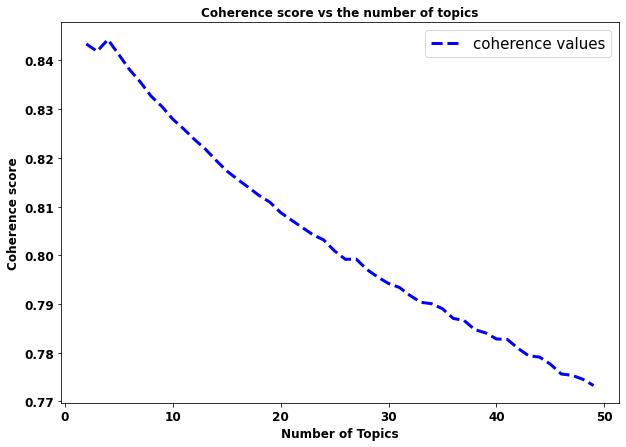

In [43]:
# Graph that show relation between coherence score and the number of topics.
import matplotlib.pyplot as plt
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.figure(figsize=(10, 7))
plt.plot(x, coherence_values,'b--',lw=3.0,label="coherence values")
plt.xlabel("Number of Topics", fontsize = 12,fontweight='bold')
plt.ylabel("Coherence score", fontsize = 12,fontweight='bold')
plt.legend(fontsize = 15,loc='best')
plt.title('Coherence score vs the number of topics', fontsize = 12,fontweight='bold')
import matplotlib as mpl
mpl.rcParams["axes.spines.right"] = False; mpl.rcParams["axes.spines.top"] = False
from pylab import *
rc('axes', linewidth=3)
fontsize = 12
ax = gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.show()

In [44]:
# The coherence scores for multiple number of topics.
for m, cv in zip(x, coherence_values):
    print("The coherence value of topics # {} = {}".format(m,round(cv, 4)))

The coherence value of topics # 2 = 0.8434
The coherence value of topics # 3 = 0.8419
The coherence value of topics # 4 = 0.8443
The coherence value of topics # 5 = 0.8412
The coherence value of topics # 6 = 0.8381
The coherence value of topics # 7 = 0.8356
The coherence value of topics # 8 = 0.8327
The coherence value of topics # 9 = 0.8305
The coherence value of topics # 10 = 0.828
The coherence value of topics # 11 = 0.826
The coherence value of topics # 12 = 0.8238
The coherence value of topics # 13 = 0.8219
The coherence value of topics # 14 = 0.8195
The coherence value of topics # 15 = 0.8173
The coherence value of topics # 16 = 0.8156
The coherence value of topics # 17 = 0.814
The coherence value of topics # 18 = 0.8123
The coherence value of topics # 19 = 0.8109
The coherence value of topics # 20 = 0.8088
The coherence value of topics # 21 = 0.8072
The coherence value of topics # 22 = 0.8057
The coherence value of topics # 23 = 0.8042
The coherence value of topics # 24 = 0.8031

In [45]:
round(max(coherence_values), 4)

0.8443

In [46]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.035*"would" + 0.024*"said" + 0.017*"well" + 0.015*"shall" + 0.013*"soon" + 0.013*"see" + 0.011*"john" + 0.009*"love" + 0.009*"brandon" + 0.009*"lady"'),
 (1,
  '0.058*"attend" + 0.058*"unreserve" + 0.056*"concealment" + 0.017*"sister" + 0.016*"time" + 0.014*"think" + 0.014*"day" + 0.013*"know" + 0.011*"first" + 0.010*"miss"'),
 (2,
  '0.059*"real" + 0.056*"aim" + 0.055*"illaudable" + 0.029*"mr" + 0.020*"one" + 0.017*"though" + 0.013*"mother" + 0.009*"say" + 0.009*"colonel" + 0.009*"may"'),
 (3,
  '0.081*"could" + 0.055*"restraint" + 0.055*"sentiment" + 0.055*"abhorred" + 0.021*"every" + 0.017*"much" + 0.013*"might" + 0.010*"good" + 0.010*"made" + 0.009*"man"'),
 (4,
  '0.060*"appeared" + 0.059*"disgrace" + 0.032*"elinor" + 0.024*"marianne" + 0.018*"must" + 0.012*"thing" + 0.012*"edward" + 0.011*"dashwood" + 0.011*"willoughby" + 0.008*"go"')]

In [47]:
# Visualizing the top 10 words on four different topics even though highgest coherrence value is for topics = 2
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, doc_term_matrix, dictionary,R=10)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.037527 -0.014651       1        1  20.736670
4     -0.107196 -0.147000       2        1  20.218267
2      0.349502  0.012074       3        1  19.733795
1     -0.091765 -0.170506       4        1  19.678420
3     -0.113015  0.320082       5        1  19.632847, topic_info=          Term         Freq        Total Category  logprob  loglift
214      could  1173.000000  1173.000000  Default  10.0000  10.0000
1473  appeared   895.000000   895.000000  Default   9.0000   9.0000
5352  disgrace   876.000000   876.000000  Default   8.0000   8.0000
37        real   861.000000   861.000000  Default   7.0000   7.0000
4851    attend   845.000000   845.000000  Default   6.0000   6.0000
...        ...          ...          ...      ...      ...      ...
1091      much   247.081157   247.794960   Topic5  -4.0743   1.6251
266      might   184.626179   185.338885   Topic5  -4.3657   1.6241
105       good   152.177848   152.890149   Topic5  -4.5590   1.6233
171       made   147.278998   147.991639   Topic5  -4.5917   1.6231
25         man   135.910161   136.622633   Topic5  -4.6720   1.6227

[67 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
11474      5  0.999201    abhorred
3397       3  0.999390         aim
1473       2  0.999030    appeared
4851       4  0.999712      attend
10870      1  0.986870     brandon
...      ...       ...         ...
10844      2  0.944706  willoughby
10844      3  0.011591  willoughby
10844      5  0.017387  willoughby
448        1  0.999581       would
424        3  0.992604         yet

[80 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 2, 4])

In [48]:
pyLDAvis.save_html(vis,'vis.html')

The below code can be used to find the dominant topic in each sentense.

In [49]:
def topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=df_books['books_text_data']):
    sent_df = pd.DataFrame()

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                kw = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in kw])
                sent_df = sent_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_df.columns = ['Dominant Topic', 'Perc_Contribution', 'Keywords']

    contents = pd.Series(texts)
    sent_df = pd.concat([sent_df, contents], axis=1)
    return(sent_df)
    
df_topic_sents_keywords = topics_sentences(ldamodel=optimal_model, corpus=doc_term_matrix, texts=df_books['books_text_data'])
df_dominant = df_topic_sents_keywords.reset_index()
df_dominant.columns = ['Document Number', 'Dominant Topic', 'Topic_Perc_Contrib', 'Keywords', 'Reference Text']
df_dominant.head(10)

,Document Number,Dominant Topic,Topic_Perc_Contrib,Keywords,Reference Text
0,0,2.0,0.5966,"real, aim, illaudable, mr, one, though, mother...",thursday comrades cried gregory in a voice lik...
1,1,0.0,0.5999,"would, said, well, shall, soon, see, john, lov...",of the peace or the hostility of the place now...
2,2,1.0,0.6000,"attend, unreserve, concealment, sister, time, ...",and let in a red subterranean light syme was s...
3,3,3.0,0.5989,"could, restraint, sentiment, abhorred, every, ...",not the muscles of a tiger or a horn on his no...
4,4,3.0,0.6000,"could, restraint, sentiment, abhorred, every, ...",mouth to put it syme sprang to his feet and sa...
5,5,3.0,0.6000,"could, restraint, sentiment, abhorred, every, ...",honour you have not wasted your time you have ...
6,6,4.0,0.5996,"appeared, disgrace, elinor, marianne, must, th...",the marquis started up with eyes flaming like ...
7,7,0.0,0.5860,"would, said, well, shall, soon, see, john, lov...",the one shining sword seemed a shower of shini...
8,8,3.0,0.6000,"could, restraint, sentiment, abhorred, every, ...",beetles barking said syme furiously snails bar...
9,9,0.0,0.6000,"would, said, well, shall, soon, see, john, lov...",up the professor made no answer but gazed in f...


The below code can help to identify most representative document in each topic

In [51]:
sent_topics_sorted_df= pd.DataFrame()
topics_group_df = df_topic_sents_keywords.groupby('Dominant Topic')

for i, grp in topics_group_df:
    sent_topics_sorted_df = pd.concat([sent_topics_sorted_df, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)
    
sent_topics_sorted_df.reset_index(drop=True, inplace=True)
sent_topics_sorted_df.columns = ['Topic Number', "Topic_Perc_Contrib", "Keywords", " Reference Text"]
sent_topics_sorted_df.head()

,Topic Number,Topic_Perc_Contrib,Keywords,Reference Text
0,0.0,0.6,"would, said, well, shall, soon, see, john, lov...",NaN
1,1.0,0.6,"attend, unreserve, concealment, sister, time, ...",and let in a red subterranean light syme was s...
2,2.0,0.6,"real, aim, illaudable, mr, one, though, mother...",NaN
3,3.0,0.6,"could, restraint, sentiment, abhorred, every, ...",NaN
4,4.0,0.6,"appeared, disgrace, elinor, marianne, must, th...",NaN
